In [ ]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!pip install opencv-python pillow

In [1]:
import torch
import torchvision
from torchvision.transforms import v2 as T
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.transform import GeneralizedRCNNTransform
import numpy as np
import cv2
import os
from PIL import Image

In [2]:
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())

2.4.0+cu121
0.19.0+cu121
True


In [ ]:
!pip install kaggle

In [3]:
torch.cuda.empty_cache()

In [ ]:
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
os.rename("/usr/local/lib/python3.10/dist-packages/kaggle/kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))

!kaggle datasets download -d balraj98/clothing-coparsing-dataset
!unzip clothing-coparsing-dataset.zip -d clothing_dataset

In [4]:
dataset_path = "./clothing_dataset"
files = os.listdir(dataset_path)
print(files)

['labels', 'class_dict.csv', 'metadata.csv', 'images', 'labels_raw']


In [ ]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

In [ ]:
!pip install pycocotools

In [108]:
clothing_classes = ["blazer", "blouse", "bodysuit", "bra",
                "cape", "cardigan", "coat", "dress",
                "hoodie", "intimate",
                "jacket", "jeans", "jumper", "leggings",
                "panties", "pants", "romper",
                "shirt", "shorts", "skirt", "suit", "sweater",
                "sweatshirt", "swimwear", "t-shirt", "tights",
                "top"]
print(len(clothing_classes))
print(clothing_classes.index("shirt"))

27
17


In [66]:
files = os.listdir('./models')
print(files)

['mask-rcnn-2-14.pth', 'mask-rcnn-5-4.pth', 'mask-rcnn-3-1.pth', 'mask-rcnn-3-2.pth', 'mask-rcnn-2-8.pth', 'mask-rcnn-6-18.pth', 'mask-rcnn-6-0.pth', 'mask-rcnn-4-0.pth', 'mask-rcnn-5-3.pth', 'mask-rcnn-2-16.pth', 'mask-rcnn-3-4.pth', 'mask-rcnn-5-5.pth', 'mask-rcnn-5-2.pth', 'mask-rcnn-2-9.pth', 'mask-rcnn-2-0.pth', 'mask-rcnn-6-12.pth', 'mask-rcnn-2-15.pth', 'mask-rcnn-2-3.pth', 'mask-rcnn-6-7.pth', 'mask-rcnn-4-3.pth', 'mask-rcnn-6-22.pth', 'mask-rcnn-6-13.pth', 'mask-rcnn-6-16.pth', 'mask-rcnn-6-8.pth', 'mask-rcnn-2-6.pth', 'mask-rcnn-5-0.pth', 'mask-rcnn8.pth', 'mask-rcnn-5-1.pth', 'mask-rcnn-6-4.pth', 'mask-rcnn-6-14.pth', 'mask-rcnn-2-7.pth', 'mask-rcnn-2-18.pth', 'mask-rcnn-5-7.pth', 'mask-rcnn-2-11.pth', 'mask-rcnn-6-9.pth', 'mask-rcnn6.pth', 'mask-rcnn-3-6.pth', 'mask-rcnn-2-19.pth', 'mask-rcnn-6-15.pth', 'mask-rcnn3.pth', 'mask-rcnn4.pth', 'mask-rcnn-3-3.pth', 'mask-rcnn-3-5.pth', 'mask-rcnn-6-2.pth', 'mask-rcnn-2-13.pth', 'mask-rcnn-5-9.pth', 'mask-rcnn-2-5.pth', 'mask-rcnn

In [ ]:
!pip install tqdm

In [19]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tqdm.notebook import tqdm

In [5]:
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from PIL import Image
import torchvision.transforms.functional as TF
import pandas as pd


image_dir = "clothing_dataset/images"
mask_dir = "clothing_dataset/labels/pixel_level_labels_colored"
data_dir = "clothing_dataset"
csv_path = 'clothing_dataset/class_dict.csv'

class ClothingSegmentationDataset_v2(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.class_dict = pd.read_csv(csv_path)
        self.clothing_colors = self.get_clothing_colors()
        self.background = [(69, 6, 90)]

        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.image_filenames = self.image_filenames[:min(len(self.image_filenames), len(self.mask_filenames))]
        self.mask_filenames = self.mask_filenames[:min(len(self.image_filenames), len(self.mask_filenames))]
            
            


    def get_clothing_colors(self):
        clothing_classes = ["blazer", "blouse", "bodysuit", "bra",
                            "cape", "cardigan", "coat", "dress",
                            "hoodie", "intimate",
                            "jacket", "jeans", "jumper", "leggings",
                            "panties", "pants", "romper",
                            "shirt", "shorts", "skirt", "suit", "sweater",
                            "sweatshirt", "swimwear", "t-shirt", "tights",
                            "top"]
        df_clothing = self.class_dict[self.class_dict["class_name"].isin(clothing_classes)]
        return [tuple(row[["r", "g", "b"]]) for _, row in df_clothing.iterrows()]

    
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        mask = Image.open(mask_path).convert("RGB")
        mask = self.rgb_mask_to_indexed(mask)

        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[obj_ids > 0]

        labels = torch.ones(len(obj_ids), dtype=torch.int64)
        for i in range(len(obj_ids)):
            if (obj_ids[i] in [13, 15, 17, 27]):
                labels[i] = 2
            if (obj_ids[i] in [2, 6, 7, 8, 12]):
                labels[i] = 3
            if (obj_ids[i] in [10, 14, 23, 24]):
                labels[i] = 4
            if (obj_ids[i] in [26, 28]):
                labels[i] = 5
            if (obj_ids[i] == 4):
                labels[i] = 6
            if (obj_ids[i] == 5):
                labels[i] = 7
            if (obj_ids[i] == 9):
                labels[i] = 8
            if (obj_ids[i] == 11):
                labels[i] = 9
            if (obj_ids[i] == 16):
                labels[i] = 10
            if (obj_ids[i] == 18):
                labels[i] = 11
            if (obj_ids[i] == 20):
                labels[i] = 12
            if (obj_ids[i] == 21):
                labels[i] = 13
            if (obj_ids[i] == 22):
                labels[i] = 14
            if (obj_ids[i] == 25):
                labels[i] = 15
            if (obj_ids[i] in [3, 19]):
                labels[i] = 16
            
            

        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
                
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = read_image(img_path)

        boxes = masks_to_boxes(masks)
    
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(obj_ids) + 1,), dtype=torch.int64)
        iscrowd[0] = 1

        img = tv_tensors.Image(image)


        target = {
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=img.shape[-2:]),
            "masks": tv_tensors.Mask(masks),
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        if self.transform is not None:
            img, target = self.transform(img, target)
             
        return img, target

    def rgb_mask_to_indexed(self, mask):
        mask = np.array(mask)  # (H, W, 3)
        indexed_mask = np.zeros(mask.shape[:2], dtype=np.int64)

        mask_indices = (mask != self.background[0]).all(axis=-1)
        indexed_mask[mask_indices] = 1

        current_index = 1
        for color in self.clothing_colors:
            mask_indices = (mask == color).all(axis=-1)
            if np.any(mask_indices):
                indexed_mask[mask_indices] = current_index + 1
            current_index += 1

        return torch.tensor(indexed_mask, dtype=torch.int64)

def get_transform(train):
    transforms = []
    transforms.append(T.Resize((650, 650)))
    transforms.append(T.ToDtype(torch.float, scale=True))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomRotation(degrees=15, expand=True, fill=1))
        transforms.append(T.CenterCrop(512))
        # transforms.append(T.RandomAffine(
        #     degrees=15,
        #     translate=(0.1, 0.1),
        #     scale=(0.9, 1.1),
        #     fill=1
        # ))
    transforms.append(T.Resize((512, 512)))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

dataset = ClothingSegmentationDataset_v2(image_dir, mask_dir, transform=get_transform(True))

In [6]:
import utils

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=utils.collate_fn,
    num_workers = 2
)

images, target = next(iter(dataloader))
print(f"Загружено {len(dataset)} изображений, размер первого: {images[0].shape}")
print(len(images))

Загружено 1004 изображений, размер первого: torch.Size([3, 512, 512])
8


tensor([ 1, 16,  8])


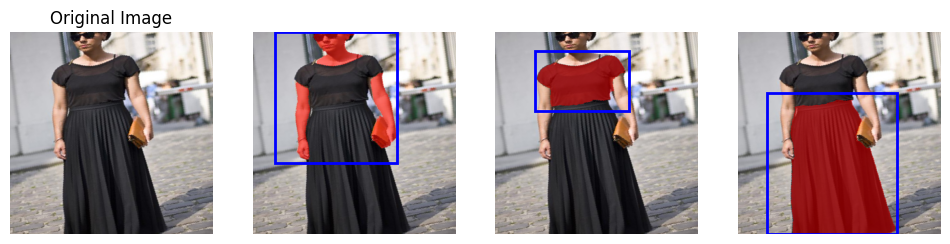

In [7]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as TF
from torchvision.utils import draw_segmentation_masks
import torch

idx = 130
image, target = dataset[idx]
print(target['labels'])
masks = target['masks']
boxes = target['boxes']

fig, ax = plt.subplots(1, len(masks) + 1, figsize=(12, 11))

ax[0].imshow(TF.to_pil_image(image))
ax[0].set_title("Original Image")
ax[0].axis("off")

# img_vis = TF.to_pil_image(image)
# img_tensor = TF.to_tensor(img_vis)

for i in range(len(masks)):
    mask_bool = masks[i] > 0
    img_with_mask = draw_segmentation_masks(image, mask_bool, alpha=0.5, colors="red")

    ax[i + 1].imshow(TF.to_pil_image(img_with_mask))
    ax[i + 1].axis("off")

    xmin, ymin, xmax, ymax = boxes[i]
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor="blue", facecolor='none')
    ax[i + 1].add_patch(rect)

plt.show()

In [8]:
dataset_test = ClothingSegmentationDataset_v2(image_dir, mask_dir, transform=get_transform(False))

In [9]:
train_size_v3 = int(0.8 * len(dataset))

indices = torch.randperm(train_size_v3).tolist()
dataset_train_v3 = torch.utils.data.Subset(dataset, indices[:-100])
dataset_val_v3 = torch.utils.data.Subset(dataset_test, indices[-100:])

train_loader_v3 = DataLoader(dataset_train_v3, batch_size=4, shuffle=True, collate_fn=utils.collate_fn, num_workers=2, pin_memory=False)
val_loader_v3 = DataLoader(dataset_val_v3, batch_size=4, shuffle=False, collate_fn=utils.collate_fn, num_workers=2, pin_memory=False)

all_indices = set(range(len(dataset))) 
indices_to_exclude = set(indices)       
remaining_indices = list(all_indices - indices_to_exclude) 

dataset_test_v3 = torch.utils.data.Subset(dataset_test, remaining_indices)
test_loader_v3 =  DataLoader(dataset_test_v3, batch_size=16, shuffle=False, collate_fn=utils.collate_fn, num_workers=2)

In [10]:
print(len(dataset_train_v3))
print(len(dataset_test_v3))

703
201


In [11]:
from engine import train_one_epoch, evaluate


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Используемое устройство:", device)

Используемое устройство: cuda


In [12]:
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights as start_weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_v4(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=start_weights.DEFAULT, box_detections_per_img=20)

    for name, param in model.backbone.named_parameters():
        if 'layer1' in name or 'layer2' in name:
            param.requires_grad = False

    
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_roi_pool = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=7,
        sampling_ratio=2
    )
    
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 512

    model.roi_heads.mask_roi_pool = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=14, 
        sampling_ratio=2
    )

    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    model.roi_heads.mask_iou_thresh = 0.7
    model.roi_heads.score_thresh = 0.05

    return model

In [13]:
class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # self.class_coef = class_coef
        # self.mask_koef = mask_koef

    # def update(self, class_coef, mask_koef):
    #     self.class_coef = class_coef
    #     self.mask_koef = mask_koef

    def forward(self, outputs, targets):
        loss_dict = outputs
        total_loss = 0
        
        classification_loss = loss_dict['loss_classifier']
        box_reg_loss = loss_dict['loss_box_reg']
        mask_loss = loss_dict['loss_mask']

        return (4.0/2.0) * classification_loss + (1.0/2.0) * box_reg_loss + (3.0/2.0) * mask_loss

In [14]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tqdm.notebook import tqdm

from contextlib import redirect_stdout
import sys
def train_loop(model, optimizer, scheduler, train_loader, val_loader, device, num_epochs):
    best_acc = 0.0
    scaler = torch.cuda.amp.GradScaler()
    
    criterion = CustomLoss()
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch +1}/{num_epochs}')

        if epoch < 3:
            for g in optimizer.param_groups:
                g['lr'] = (epoch + 1) / 3 * 1e-4

        for images, targets in progress_bar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
            
            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = criterion(loss_dict, targets)
            
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += losses.item()
            
        print(epoch_loss)

        if epoch % 3 == 2:
            print("\n=== Начало валидации ===")
            with redirect_stdout(sys.stdout):
                coco_evaluator = evaluate(model, val_loader, device=device)
            print("=== Валидация завершена ===\n")
        if epoch >= 3:
            scheduler.step()
        model.eval()
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model_v4.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': scheduler.state_dict()
        }
        torch.save(checkpoint, f'./models/mask-rcnn-6-{epoch}.pth')

In [15]:
model_v4 = get_model_v4(num_classes=17)
optimizer_v4 = torch.optim.AdamW(model_v4.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler_v4 = torch.optim.lr_scheduler.StepLR(optimizer_v4,
                                               step_size=2,
                                               gamma=0.6)

model_v4.to(device)

train_loop(
    model_v4,
    optimizer_v4,
    scheduler_v4,
    train_loader_v3,
    val_loader_v3,
    device,
    num_epochs=30
)

/tmp/ipykernel_279818/3063098091.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/30:   0%|          | 0/176 [00:00<?, ?it/s]

256.24174416065216


Epoch 2/30:   0%|          | 0/176 [00:00<?, ?it/s]

179.4838569164276


Epoch 3/30:   0%|          | 0/176 [00:00<?, ?it/s]

155.96797227859497

=== Начало валидации ===
creating index...
index created!
Test:  [ 0/25]  eta: 0:00:46  model_time: 0.1980 (0.1980)  evaluator_time: 0.0333 (0.0333)  time: 1.8727  data: 1.6392  max mem: 3742
Test:  [24/25]  eta: 0:00:00  model_time: 0.1811 (0.1878)  evaluator_time: 0.0372 (0.0435)  time: 0.7611  data: 0.5292  max mem: 3742
Test: Total time: 0:00:20 (0.8080 s / it)
Averaged stats: model_time: 0.1811 (0.1878)  evaluator_time: 0.0372 (0.0435)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.111
 Average Precisi

Epoch 4/30:   0%|          | 0/176 [00:00<?, ?it/s]

134.52174842357635


Epoch 5/30:   0%|          | 0/176 [00:00<?, ?it/s]

124.01159179210663


Epoch 6/30:   0%|          | 0/176 [00:00<?, ?it/s]

107.58165311813354

=== Начало валидации ===
creating index...
index created!
Test:  [ 0/25]  eta: 0:00:46  model_time: 0.1915 (0.1915)  evaluator_time: 0.0261 (0.0261)  time: 1.8648  data: 1.6451  max mem: 3772
Test:  [24/25]  eta: 0:00:00  model_time: 0.1765 (0.1796)  evaluator_time: 0.0295 (0.0313)  time: 0.7719  data: 0.5626  max mem: 3772
Test: Total time: 0:00:20 (0.8185 s / it)
Averaged stats: model_time: 0.1765 (0.1796)  evaluator_time: 0.0295 (0.0313)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.203
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.089
 Average Precisi

Epoch 7/30:   0%|          | 0/176 [00:00<?, ?it/s]

101.51830485463142


Epoch 8/30:   0%|          | 0/176 [00:00<?, ?it/s]

90.03716185688972


Epoch 9/30:   0%|          | 0/176 [00:00<?, ?it/s]

84.82645559310913

=== Начало валидации ===
creating index...
index created!
Test:  [ 0/25]  eta: 0:00:43  model_time: 0.1782 (0.1782)  evaluator_time: 0.0230 (0.0230)  time: 1.7527  data: 1.5496  max mem: 3772
Test:  [24/25]  eta: 0:00:00  model_time: 0.1670 (0.1711)  evaluator_time: 0.0234 (0.0244)  time: 0.7308  data: 0.5364  max mem: 3772
Test: Total time: 0:00:19 (0.7734 s / it)
Averaged stats: model_time: 0.1670 (0.1711)  evaluator_time: 0.0234 (0.0244)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.110
 Average Precisio

Epoch 10/30:   0%|          | 0/176 [00:00<?, ?it/s]

78.11983327567577


Epoch 11/30:   0%|          | 0/176 [00:00<?, ?it/s]

74.78978109359741


Epoch 12/30:   0%|          | 0/176 [00:00<?, ?it/s]

70.91654282808304

=== Начало валидации ===
creating index...
index created!
Test:  [ 0/25]  eta: 0:00:46  model_time: 0.1785 (0.1785)  evaluator_time: 0.0235 (0.0235)  time: 1.8567  data: 1.6525  max mem: 3772
Test:  [24/25]  eta: 0:00:00  model_time: 0.1670 (0.1713)  evaluator_time: 0.0230 (0.0243)  time: 0.7757  data: 0.5821  max mem: 3772
Test: Total time: 0:00:20 (0.8197 s / it)
Averaged stats: model_time: 0.1670 (0.1713)  evaluator_time: 0.0230 (0.0243)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.437
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.162
 Average Precisio

Epoch 13/30:   0%|          | 0/176 [00:00<?, ?it/s]

67.3136276602745


Epoch 14/30:   0%|          | 0/176 [00:00<?, ?it/s]

65.26686808466911


Epoch 15/30:   0%|          | 0/176 [00:00<?, ?it/s]

63.389322221279144

=== Начало валидации ===
creating index...
index created!
Test:  [ 0/25]  eta: 0:00:42  model_time: 0.1771 (0.1771)  evaluator_time: 0.0230 (0.0230)  time: 1.7142  data: 1.5110  max mem: 3772
Test:  [24/25]  eta: 0:00:00  model_time: 0.1672 (0.1701)  evaluator_time: 0.0223 (0.0234)  time: 0.6980  data: 0.5052  max mem: 3772
Test: Total time: 0:00:18 (0.7416 s / it)
Averaged stats: model_time: 0.1672 (0.1701)  evaluator_time: 0.0223 (0.0234)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.221
 Average Precisi

Epoch 16/30:   0%|          | 0/176 [00:00<?, ?it/s]

61.44945798814297


Epoch 17/30:   0%|          | 0/176 [00:00<?, ?it/s]

61.184973642230034


Epoch 18/30:   0%|          | 0/176 [00:00<?, ?it/s]

60.60618814826012

=== Начало валидации ===
creating index...
index created!
Test:  [ 0/25]  eta: 0:00:47  model_time: 0.1808 (0.1808)  evaluator_time: 0.0258 (0.0258)  time: 1.9047  data: 1.6960  max mem: 3772
Test:  [24/25]  eta: 0:00:00  model_time: 0.1652 (0.1692)  evaluator_time: 0.0210 (0.0234)  time: 0.7817  data: 0.5917  max mem: 3772
Test: Total time: 0:00:20 (0.8274 s / it)
Averaged stats: model_time: 0.1652 (0.1692)  evaluator_time: 0.0210 (0.0234)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.165
 Average Precisio

Epoch 19/30:   0%|          | 0/176 [00:00<?, ?it/s]

59.700448393821716


Epoch 20/30:   0%|          | 0/176 [00:00<?, ?it/s]

59.36288544535637


Epoch 21/30:   0%|          | 0/176 [00:00<?, ?it/s]

59.173031985759735

=== Начало валидации ===
creating index...
index created!
Test:  [ 0/25]  eta: 0:00:45  model_time: 0.1731 (0.1731)  evaluator_time: 0.0214 (0.0214)  time: 1.8102  data: 1.6136  max mem: 3802
Test:  [24/25]  eta: 0:00:00  model_time: 0.1646 (0.1688)  evaluator_time: 0.0223 (0.0228)  time: 0.7610  data: 0.5704  max mem: 3802
Test: Total time: 0:00:20 (0.8034 s / it)
Averaged stats: model_time: 0.1646 (0.1688)  evaluator_time: 0.0223 (0.0228)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.460
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.171
 Average Precisi

Epoch 22/30:   0%|          | 0/176 [00:00<?, ?it/s]

58.79783947765827


Epoch 23/30:   0%|          | 0/176 [00:00<?, ?it/s]

58.86710947751999


Epoch 24/30:   0%|          | 0/176 [00:00<?, ?it/s]

58.3689539283514

=== Начало валидации ===
creating index...
index created!
Test:  [ 0/25]  eta: 0:00:44  model_time: 0.1776 (0.1776)  evaluator_time: 0.0217 (0.0217)  time: 1.7726  data: 1.5710  max mem: 3802
Test:  [24/25]  eta: 0:00:00  model_time: 0.1645 (0.1689)  evaluator_time: 0.0213 (0.0225)  time: 0.7264  data: 0.5357  max mem: 3802
Test: Total time: 0:00:19 (0.7694 s / it)
Averaged stats: model_time: 0.1645 (0.1689)  evaluator_time: 0.0213 (0.0225)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.174
 Average Precision

Epoch 25/30:   0%|          | 0/176 [00:00<?, ?it/s]

58.780394837260246


Epoch 26/30:   0%|          | 0/176 [00:00<?, ?it/s]

58.14007160067558


Epoch 27/30:   0%|          | 0/176 [00:00<?, ?it/s]

57.957797795534134

=== Начало валидации ===
creating index...
index created!
Test:  [ 0/25]  eta: 0:00:45  model_time: 0.1757 (0.1757)  evaluator_time: 0.0224 (0.0224)  time: 1.8219  data: 1.6214  max mem: 3820
Test:  [24/25]  eta: 0:00:00  model_time: 0.1654 (0.1687)  evaluator_time: 0.0216 (0.0228)  time: 0.7643  data: 0.5734  max mem: 3820
Test: Total time: 0:00:20 (0.8070 s / it)
Averaged stats: model_time: 0.1654 (0.1687)  evaluator_time: 0.0216 (0.0228)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.451
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.176
 Average Precisi

Epoch 28/30:   0%|          | 0/176 [00:00<?, ?it/s]

58.2329683303833


Epoch 29/30:   0%|          | 0/176 [00:00<?, ?it/s]

57.95860815048218


Epoch 30/30:   0%|          | 0/176 [00:00<?, ?it/s]

58.15320082008839

=== Начало валидации ===
creating index...
index created!
Test:  [ 0/25]  eta: 0:00:45  model_time: 0.1763 (0.1763)  evaluator_time: 0.0243 (0.0243)  time: 1.8221  data: 1.6195  max mem: 3871
Test:  [24/25]  eta: 0:00:00  model_time: 0.1655 (0.1701)  evaluator_time: 0.0214 (0.0235)  time: 0.7521  data: 0.5595  max mem: 3871
Test: Total time: 0:00:19 (0.7972 s / it)
Averaged stats: model_time: 0.1655 (0.1701)  evaluator_time: 0.0214 (0.0235)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.455
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.166
 Average Precisio

In [22]:
model_v4 = get_model_v4(num_classes=17)
checkpoint = torch.load('./models/mask-rcnn-6-21.pth', map_location=device)

model_v4.load_state_dict(checkpoint['model_state_dict'])
model_v4.to(device)

/tmp/ipykernel_279818/1880702817.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./models/mask-rcnn-6-21.pth', map_location=device)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [52]:
example_path = './clothing_dataset/images/1040.jpg'

def get_transform_vis():
    transforms = []
    transforms.append(T.Resize((512, 512)))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


to_tensor = get_transform_vis()

image = read_image(example_path)
example_img = to_tensor(image)

model_v4.eval()

with torch.no_grad():
    prediction = model_v4([example_img.to(device)])

In [53]:
import torchvision.transforms as transforms
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes

to_pil_image = transforms.ToPILImage()
byte_img = example_img.mul(255).byte()

In [54]:
def mask_on_image(byte_img, prediction, th_mask=0.5, th_box=0):
    masks = torch.squeeze(prediction[0]['masks']).cpu()
    labels = torch.squeeze(prediction[0]['labels']).cpu()
    scores = torch.squeeze(prediction[0]['scores']).cpu()
    threshold = torch.Tensor([th_mask])
    masks = (masks > threshold).bool()
    ans = []
    for i in range(len(masks)):
        if (scores[i] < th_box):
            continue
        masks_on_image = draw_segmentation_masks(
              image = byte_img,
              masks = masks[i],
              alpha=0.6,
              colors = 'red'
              )
        ans.append((to_pil_image(masks_on_image), labels[i], scores[i]))
    return ans

In [55]:
ans = mask_on_image(byte_img, prediction)
print(ans)

[(<PIL.Image.Image image mode=RGB size=512x512 at 0x7F427DF06F20>, tensor(12), tensor(0.9929)), (<PIL.Image.Image image mode=RGB size=512x512 at 0x7F427DE67BB0>, tensor(1), tensor(0.9925)), (<PIL.Image.Image image mode=RGB size=512x512 at 0x7F427DED7D30>, tensor(3), tensor(0.9419)), (<PIL.Image.Image image mode=RGB size=512x512 at 0x7F427DED7E80>, tensor(16), tensor(0.9279)), (<PIL.Image.Image image mode=RGB size=512x512 at 0x7F427DED4130>, tensor(5), tensor(0.3708)), (<PIL.Image.Image image mode=RGB size=512x512 at 0x7F427DED7D60>, tensor(16), tensor(0.2181)), (<PIL.Image.Image image mode=RGB size=512x512 at 0x7F427DED7D00>, tensor(4), tensor(0.1708)), (<PIL.Image.Image image mode=RGB size=512x512 at 0x7F427DED7E50>, tensor(4), tensor(0.1702)), (<PIL.Image.Image image mode=RGB size=512x512 at 0x7F427DED64D0>, tensor(12), tensor(0.1671)), (<PIL.Image.Image image mode=RGB size=512x512 at 0x7F428C2B87C0>, tensor(1), tensor(0.0594))]


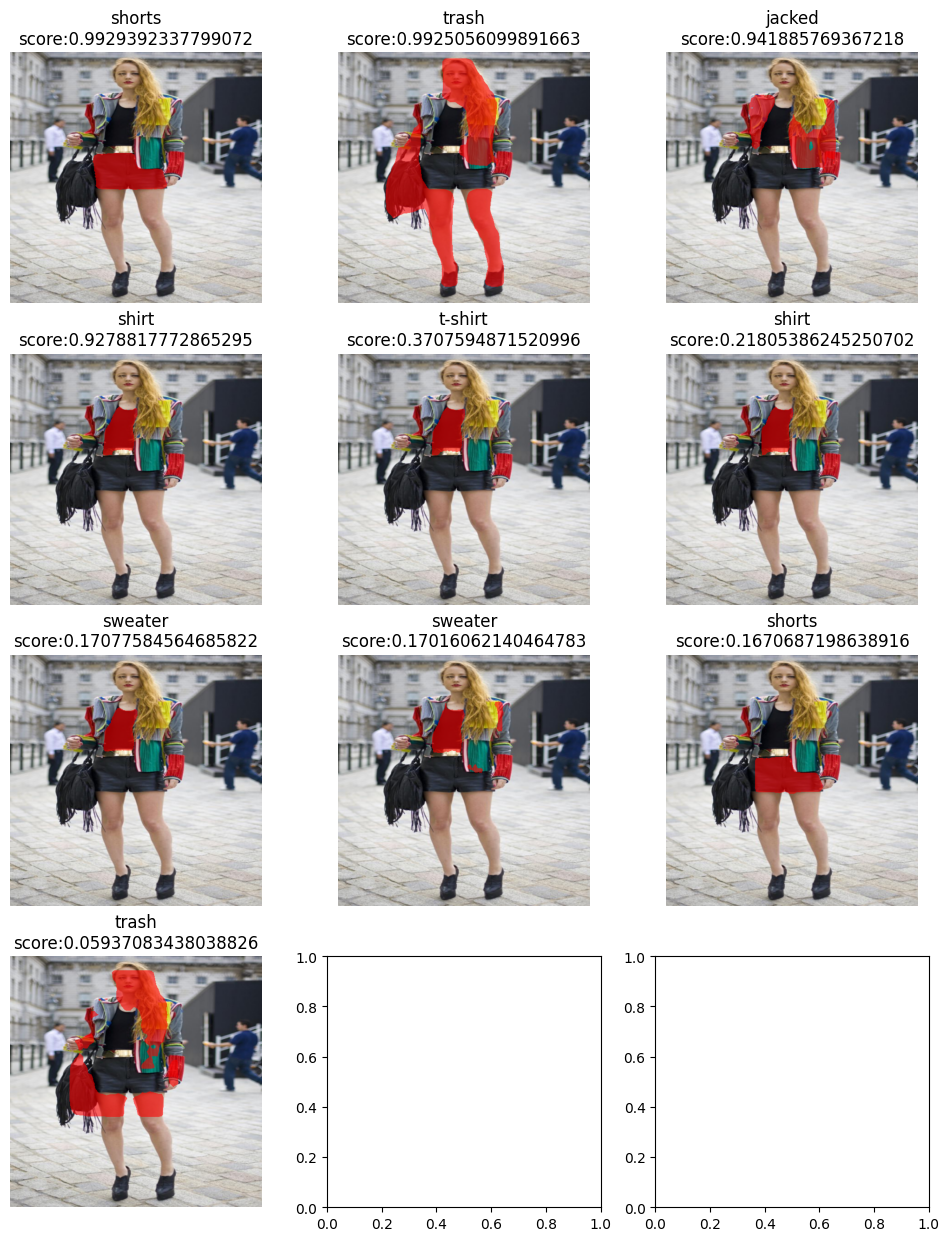

In [56]:
fig, ax = plt.subplots(len(ans) // 3 + 1 if len(ans) >= 3 else len(ans) // 3 + 2, 3, figsize=(12, len(ans) * 3 // 2))

clothing_classes = ["blazer", "blouse", "bodysuit", "bra",
                            "cape", "cardigan", "coat", "dress",
                            "hoodie", "intimate",
                            "jacket", "jeans", "jumper", "leggings",
                            "panties", "pants", "romper",
                            "shirt", "shorts", "skirt", "suit", "sweater",
                            "sweatshirt", "swimwear", "t-shirt", "tights",
                            "top"]

names = ['pants', 'jacked', 'sweater', 't-shirt', 'bodysuit', 'bra', 'dress', 'intimate', 'panties', 'romper', 'shorts',
         'skirt', 'suit', 'swimwear', 'shirt']

for i in range(len(ans)):

    ax[i // 3][i % 3].imshow(ans[i][0])
    label = names[ans[i][1] - 2] if ans[i][1] > 1 else 'trash'
        
    ax[i // 3][i % 3].set_title(f"{label}\nscore:{ans[i][2]}")
    ax[i // 3][i % 3].axis("off")

plt.show()

In [57]:
evaluate(model_v4, test_loader_v3, device=device)

creating index...
index created!
Test:  [ 0/13]  eta: 0:01:22  model_time: 0.7809 (0.7809)  evaluator_time: 0.0944 (0.0944)  time: 6.3412  data: 5.4573  max mem: 6035
Test:  [12/13]  eta: 0:00:02  model_time: 0.7070 (0.6895)  evaluator_time: 0.0810 (0.0789)  time: 2.9240  data: 2.1479  max mem: 6035
Test: Total time: 0:00:38 (2.9279 s / it)
Averaged stats: model_time: 0.7070 (0.6895)  evaluator_time: 0.0810 (0.0789)
Accumulating evaluation results...
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.438
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max